## Time Series Modeling

Time series provide the opportunity to predict/forecast future values based on previous values. Such analyses can be used to forecast trends in economics, weather, and capacity planning etc. The specific properties of time series data mean that specialized statistical methods are usually required.

### Dataset
"Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.," which collected CO2 samples from March 1958 to December 2001. 

This dataset comes from the statsmodels library

In [107]:
#make necessary imports and initial data #maipulation to visualize the time series
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
import itertools
import warnings 
warnings.filterwarnings('ignore')

In [108]:
data = sm.datasets.co2.load().data
df = pd.DataFrame(data)

In [109]:
#update index to datetime type
df['date'] = pd.to_datetime(df['index'])
#set as index
df.set_index(df['date'], inplace=True)

In [110]:
df.drop(['date', 'index'], axis=1, inplace=True)

In [111]:
df.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [112]:
df.tail()

,co2
date,
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3
2001-12-29,371.5


In [113]:
df = df.asfreq('W-SAT')

In [115]:
#'MS' groups the data in buckets by start of the month
co2 = df['co2'].resample('MS').mean()

In [116]:
co2.isna().sum()

5

In [117]:
#filling missing values with values from the next entries -> backfilling
co2.fillna(co2.bfill(), inplace=True)

In [118]:
co2.head()

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

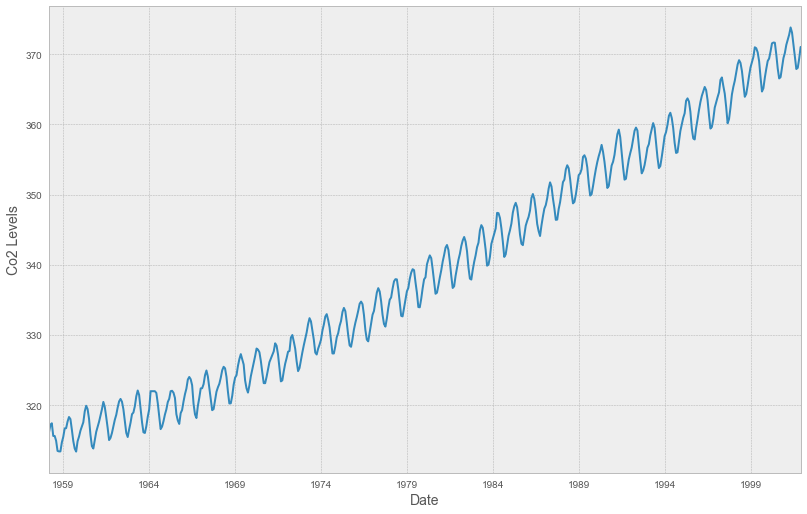

In [135]:
#visualizing the series
co2.plot(figsize=(12,8))
plt.xlabel('Date', fontsize=14)
plt.ylabel('Co2 Levels', fontsize=14)
plt.savefig('figures/co2_time_series.png', transparent=True)
plt.show()

the time series appears to display an overall increasing trend with obvious seasonal pattern

## ARIMA Time Series Model
**A**uto**R**egressive **I**ntegrated **M**oving **A**verage is the most common methods used in time series forecasting. the model can be fit to time series data to better understand or predict future points in the series.

The main parameters of the model are the **p**, **d**, **q** terms. 

Number of AR (Auto-Regressive) terms (p)

p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

Number of Differences (d)

d is the Integrated component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last n days is small.

Number of MA (Moving Average) terms (q)

q is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

- (p, d, q) are the non-seasonal parameters described above.
- (P, D, Q) follow the same definition but are applied to the seasonal component of the time series.
- The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.)



In [13]:
#setting up framework for grid search
p = d = q = range(0,2)
#setting up p,d,q values for arima
pdq = list(itertools.product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [14]:
#setting up (P,D,Q, 12) for seasonal component
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### AIC (Akaike Information Criterion) as Regularization Measure
For evaluating the models, AIC value shall be used. The AIC is an estimator of the relative quality of the statistical model for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. AIC provides a means for model selection.

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. To achieve this, perform following tasks:

- Initialize an empty list to store results
- Iterate through all the paramaters in pdq with parameters in seasonal pdq (nested loop ) to create a grid
- Run SARIMAX from statsmodels for each iteration. 
(Setting enforce_stationarity and enforce_invertibility to False)
- Get the results in each iteration with model.fit() and store the AIC values
- Find the lowest AIC and select parameters for further analysis


In [15]:
aic_scores = []
for comb in pdq:
    for combs in pdqs:
        try:
            model = sm.tsa.statespace.SARIMAX(co2,
            order=comb, 
            seasonal_order=combs, 
            enforce_stationarity=False, 
            enforce_invertibility=False)

            output = model.fit()
            aic_scores.append([comb, combs, output.aic])
            print('SARIMA {} X {} : AIC = {}'.format(comb, combs, output.aic))
        except:
            continue        

SARIMA (0, 0, 0) X (0, 0, 0, 12) : AIC = 7612.583429881011
SARIMA (0, 0, 0) X (0, 0, 1, 12) : AIC = 6787.343623901415
SARIMA (0, 0, 0) X (0, 1, 0, 12) : AIC = 1854.828234141261
SARIMA (0, 0, 0) X (0, 1, 1, 12) : AIC = 1596.7111727646184
SARIMA (0, 0, 0) X (1, 0, 0, 12) : AIC = 1058.9388921320035
SARIMA (0, 0, 0) X (1, 0, 1, 12) : AIC = 1056.2878623868849
SARIMA (0, 0, 0) X (1, 1, 0, 12) : AIC = 1361.6578978072075
SARIMA (0, 0, 0) X (1, 1, 1, 12) : AIC = 1044.7647912755078
SARIMA (0, 0, 1) X (0, 0, 0, 12) : AIC = 6881.048755170184
SARIMA (0, 0, 1) X (0, 0, 1, 12) : AIC = 6072.662327143345
SARIMA (0, 0, 1) X (0, 1, 0, 12) : AIC = 1379.194106734662
SARIMA (0, 0, 1) X (0, 1, 1, 12) : AIC = 1241.4174716895225
SARIMA (0, 0, 1) X (1, 0, 0, 12) : AIC = 1091.3600151738028
SARIMA (0, 0, 1) X (1, 0, 1, 12) : AIC = 780.4315550582799
SARIMA (0, 0, 1) X (1, 1, 0, 12) : AIC = 1119.5957893614268
SARIMA (0, 0, 1) X (1, 1, 1, 12) : AIC = 807.091298811366
SARIMA (0, 1, 0) X (0, 0, 0, 12) : AIC = 1675.808

In [17]:
aic_scores_df = pd.DataFrame(aic_scores, columns=['pdq', 'pdqs', 'aic'])
aic_scores_df.sort_values(by=['aic'], inplace=True)
aic_scores_df.head()

,pdq,pdqs,aic
63,"(1, 1, 1)","(1, 1, 1, 12)",277.780220
31,"(0, 1, 1)","(1, 1, 1, 12)",281.519018
47,"(1, 0, 1)","(1, 1, 1, 12)",285.765178
55,"(1, 1, 0)","(1, 1, 1, 12)",293.742622
59,"(1, 1, 1)","(0, 1, 1, 12)",295.937406


The output of our search suggests that SARIMA(1, 1, 1) X (1, 1, 1, 12) yields the lowest AIC value of 277.78 . We should therefore consider this to be optimal option out of all the models we have considered.

### Fitting a SARIMA Time Series Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model.


In [18]:
# Plug the optimal parameter values into a new SARIMAX model
sarima_model = sm.tsa.statespace.SARIMAX(co2, 
order= (1,1,1), 
seasonal_order=(1,1,1,12), 
enforce_stationarity=False,
enforce_invertibility=False)

# Fit the model and print results
result = sarima_model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -133.890
Date:                            Mon, 05 Oct 2020   AIC                            277.780
Time:                                    22:22:14   BIC                            298.843
Sample:                                03-01-1958   HQIC                           286.046
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.441      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.633      0.000       0.089       0.106
===================================================================================
Ljung-Box (Q):                       36.21   Jarque-Bera (JB):               187.89
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.40
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
#let's take a closer look at the coefficients
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.441      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.633      0.000       0.089       0.106


The `coef` column above shows the importance of each feature and how each one impacts the time series patterns. The $P>|z|$ provides the significance of each feature weight.

For our time-series, we see that each weight has a p-value lower or close to 0.05. Hence its safe to say that each AR and MA term in our model are significant and we can retain them.

We now run model diagnostics to check that none of the assumptions made by the model have been violated.


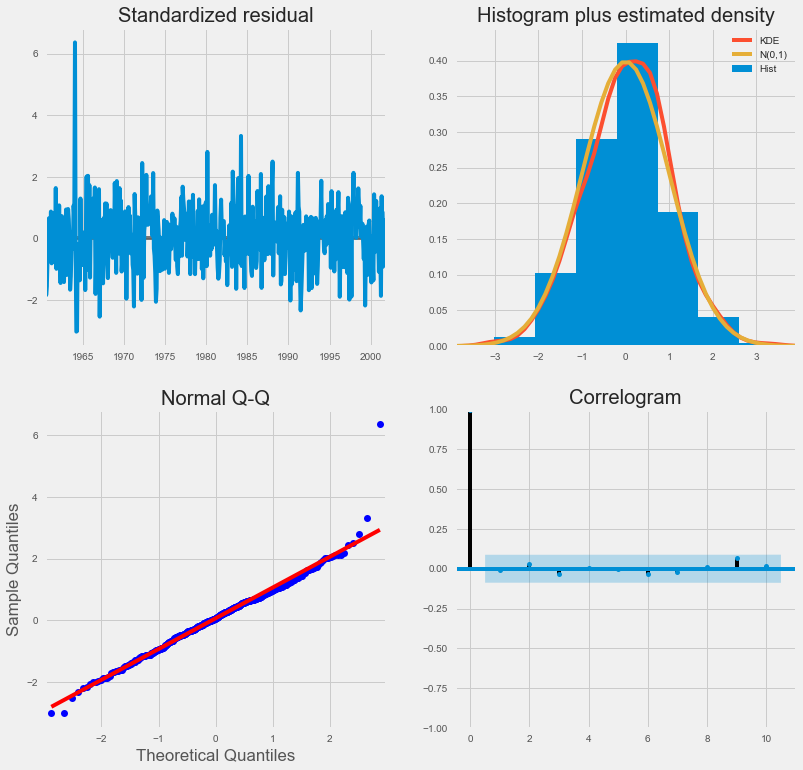

In [122]:
plt.style.use('fivethirtyeight')
result.plot_diagnostics(figsize=(12,12))
plt.savefig('figures/model_diagnostics.png', transparent=True)
plt.show()

The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

Let's check for these assumptions from diagnostics plots.

- In the top right histogram and the qq-plot on the bottom left show that the residuals are normally distributed.

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

#### One-Step Ahead Forecasting

In order to validate the model, we start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.

In [22]:
#predictions from 1st January 1998 till 2002 (end of time series)
#set the dynamic parameter to False to ensure that we produce one-step ahead forecasts,
#meaning that forecasts at each point are generated using the full history up to that point
preds = result.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)

#confidence intervals for all predictions
preds_conf = preds.conf_int()

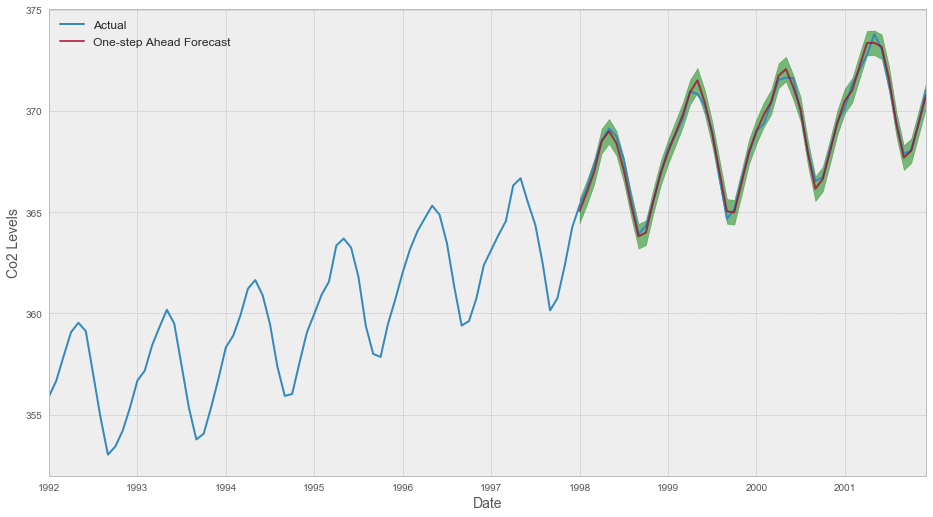

In [129]:
plt.style.use('bmh')
rcParams['figure.figsize'] = 14,8
ax = co2['1992':].plot(label='Actual')
preds.predicted_mean.plot(ax=ax, label='One-step Ahead Forecast', alpha=.75)
ax.fill_between(preds_conf.index,
               preds_conf.iloc[:, 0],
               preds_conf.iloc[:, 1],
               color = 'green',
               alpha = 0.5)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Co2 Levels', fontsize=14)
plt.legend(fontsize=12)
plt.savefig('figures/one_step_ahead_forecast.png', transparent=True)
plt.show();

The forecasts align with the true values as seen above, with overall increase trend. We shall also check for the accuracy of our forecasts using MSE (Mean Squared Error).

In [83]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(co2['1998':], preds.predicted_mean)
print('The Mean Squared Error of our Forecast is {}'.format(round(mse, 2)))

The Mean Squared Error of our Forecast is 0.07


The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low. 

### Dynamic Forecasting

We can achieve a deeper insight into model's predictive power using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In [57]:
dynamic_preds = result.get_prediction(start= pd.to_datetime('1998-01-01'), dynamic=True)
dynamic_preds_conf = dynamic_preds.conf_int()

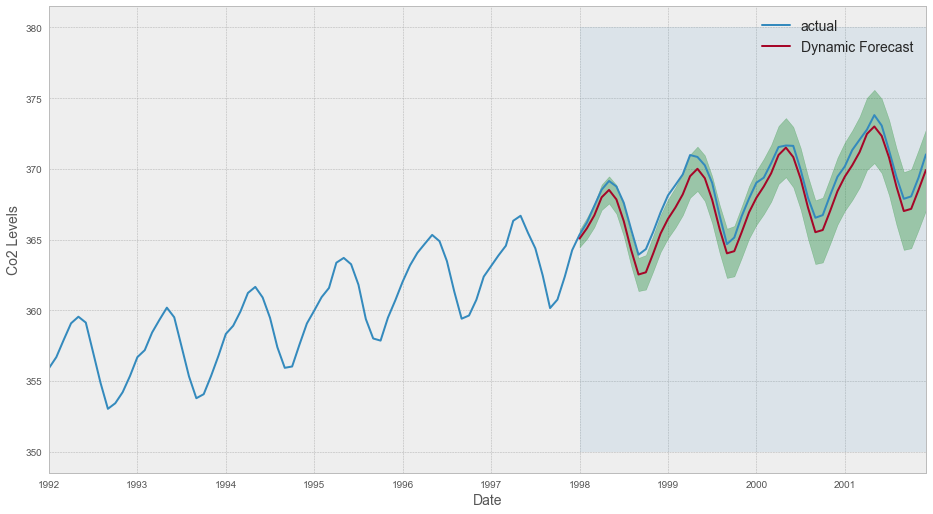

In [130]:
#visualizing the dynamic forecast
ax = co2['1992':].plot(label='actual', figsize=(14,8))
dynamic_preds.predicted_mean.plot(ax=ax, label='Dynamic Forecast')
ax.fill_between(dynamic_preds_conf.index,
               dynamic_preds_conf.iloc[:, 0],
               dynamic_preds_conf.iloc[:, 1],
               color = 'green',
               alpha=0.3)
ax.fill_between(dynamic_preds_conf.index, 350, 380, alpha=0.1)

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Co2 Levels', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('figures/dynamic_forecast.png', transparent=True)
plt.show();

We quantify the predictive performance of our forecasts by computing the MSE.

In [84]:
mse_dynamic_forecast = mean_squared_error(co2['1998':], dynamic_preds.predicted_mean)
print('The Mean Squared Error of Dynamic Forecast is {}'.format(round(mse_dynamic_forecast, 2)))

The Mean Squared Error of Dynamic Forecast is 1.01


The predicted values from the dynamic forecasting yields an MSE of 1.01. Slightly higher than the one step forecasting (expected as the model is relying on less historical data from the time series). 

### Producing and Visualizing Forecasts

In [85]:
#get forecast 300 steps ahead in future
forecast = result.get_forecast(steps=300)
#get confidence intervals for forecasts
forecast_conf = forecast.conf_int()

Using the above code to visualize the forecasts

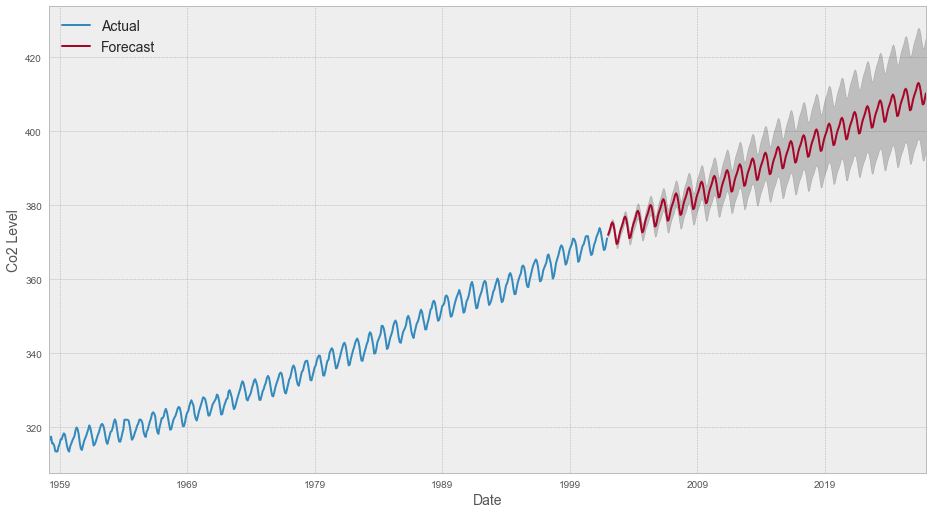

In [131]:
ax = co2.plot(figsize=(14,8), label='Actual')
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_conf.index,
               forecast_conf.iloc[:, 0],
               forecast_conf.iloc[:, 1],
               color= 'black',
               alpha=0.2)
plt.legend(loc='upper left', fontsize = 14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Co2 Level', fontsize=14)
plt.savefig('figures/forecast.png', transparent=True)
plt.show();

Forecasts show that the time series is expected to continue increasing at a steady pace.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

In [132]:
forecast.predicted_mean[:12]

2002-01-01    371.977655
2002-02-01    372.749097
2002-03-01    373.662308
2002-04-01    374.859622
2002-05-01    375.345757
2002-06-01    374.768599
2002-07-01    373.247948
2002-08-01    371.222308
2002-09-01    369.512074
2002-10-01    369.720392
2002-11-01    371.072172
2002-12-01    372.481360
Freq: MS, dtype: float64